In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
!pip3 install sentence-transformers
from sentence_transformers import SentenceTransformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 2.1 MB/s 
     |████████████████████████████████| 4.4 MB 32.1 MB/s 
     |████████████████████████████████| 1.2 MB 53.8 MB/s 
     |████████████████████████████████| 86 kB 4.8 MB/s 
     |████████████████████████████████| 596 kB 53.1 MB/s 
     |████████████████████████████████| 6.6 MB 9.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=2f103006bee1fbe20bfaff76b8468707c4a0d43d3afd4250f2eb162144af76e5
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


##Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from zipfile import ZipFile
file_name="/content/drive/MyDrive/book.zip"
with ZipFile (file_name,'r') as zip:
   zip.extractall()
   print('Done')

Done


In [ ]:
#Load pre-trained SentenceBERT model
#bert = SentenceTransformer('bert-base-nli-mean-tokens')

In [5]:
book = pd.read_csv('Books.csv', header=0)

In [6]:
book1 =  book.sample(frac=0.02)

In [19]:
book1.shape

(5427, 8)

In [20]:
book1['Book-Author'].fillna(book1['Book-Title'],inplace=True)

In [21]:
book1['Publisher'].fillna(book1['Book-Title'],inplace=True)

In [27]:
book1['Year-Of-Publication'] =book1['Year-Of-Publication'].astype(int)

In [28]:
threshold_date = 2022
books = book1[book1['Year-Of-Publication'] < threshold_date]

In [34]:
book1.shape

(5427, 8)

In [29]:
rating = pd.read_csv('Ratings.csv', header=0)
user = pd.read_csv('Users.csv', header=0)

In [30]:
rating.shape

(1149780, 3)

In [31]:
rating1 = rating[rating.ISBN.isin(book1.ISBN)]

In [32]:
rating1 = rating1[rating1['Book-Rating']!=0]

In [33]:
rating1.shape

(8288, 3)

In [35]:
user.shape

(278858, 3)

#EDA

In [36]:
book1.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

In [37]:
book1 = book1[book1['Book-Author'].notna()]

In [38]:
book1.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

In [39]:
#27136
book1.shape

(5427, 8)

In [40]:
rating.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [41]:
book1.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

Text(0.5, 1.0, 'Book-Author')

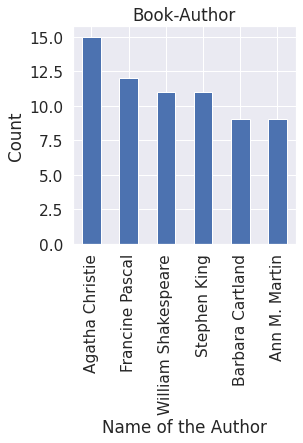

In [42]:
sns.set(font_scale= 1.4)
book1['Book-Author'].value_counts()[:6].plot(kind='bar', figsize=(4,4), 
                                                      xlabel='Name of the Author', 
                                                      ylabel='Count')

plt.title("Book-Author")

Text(0.5, 1.0, 'Year-Of-Publication')

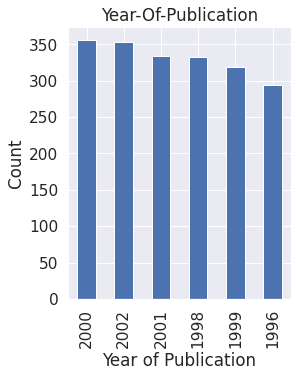

In [43]:
sns.set(font_scale= 1.4)
book1['Year-Of-Publication'].value_counts()[:6].plot(kind='bar', figsize=(4,5), 
                                                      xlabel='Year of Publication', 
                                                      ylabel='Count')

plt.title("Year-Of-Publication")

In [44]:
book1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5427 entries, 248247 to 204270
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ISBN                 5427 non-null   object
 1   Book-Title           5427 non-null   object
 2   Book-Author          5427 non-null   object
 3   Year-Of-Publication  5427 non-null   int64 
 4   Publisher            5427 non-null   object
 5   Image-URL-S          5427 non-null   object
 6   Image-URL-M          5427 non-null   object
 7   Image-URL-L          5427 non-null   object
dtypes: int64(1), object(7)
memory usage: 381.6+ KB


In [61]:
df1 = rating1.merge(books, how="left", on="ISBN")

In [63]:
df1.shape

(8288, 10)

## Popularity Recommender

In [67]:
#1149780
threshold_date = 1998
ids = book1[book1['Year-Of-Publication'] < threshold_date]['ISBN'].values

training_data = df1[df1['ISBN'].isin(ids)]
print(f'Training data size: {training_data.shape}')

#~ is not in ratings
testing_data = df1[~df1['ISBN'].isin(ids)]
print(f'Testing data size: {testing_data.shape}')

Training data size: (4019, 10)
Testing data size: (4269, 10)


In [68]:
testing_data = testing_data[testing_data['User-ID'].isin(training_data['User-ID'])]
testing_data.shape

(1249, 10)

In [51]:
def get_favorite_books(user_id, ratings_df):
    favorites = ratings_df[(ratings_df['User-ID'] == user_id) & (ratings_df['Book-Rating'] >= 3.5)].sort_values(by='Book-Rating', ascending=False)['ISBN']
    return set(favorites if type(favorites) == pd.Series else [favorites])

In [52]:
class ModelEvaluator:
  def __init__(self, training_data, testing_data, threshold=6.5):
    self.training_data = training_data
    self.testing_data = testing_data
    self.threshold = threshold

  def evaluate_model_for_user(self, model, user_id):
      #Getting the items in test set
      favorites_in_test = get_favorite_books(user_id, self.testing_data)
      #print(favorites_in_test)
      
      #Getting a ranked recommendation list from a model for a given user (movieId, predicted_rating)
      person_recs_df = model.recommend_items(user_id, 
                                              items_to_ignore=get_favorite_books(user_id, self.training_data))
     # print(person_recs_df)
      # get only movies with predicated rating >= 3.5
      person_recs_df = person_recs_df[person_recs_df['predicted_rating'] >= self.threshold].sort_values(by='predicted_rating', ascending=False)
      true_relevent = person_recs_df[person_recs_df['ISBN'].isin(favorites_in_test)].shape[0]

      top_5_recommended = person_recs_df.head(5)
      top_10_recommended = person_recs_df.head(10)

      # Number of relevant and recommended items in top k
      hits_at_5_count = top_5_recommended[top_5_recommended['ISBN'].isin(favorites_in_test)].shape[0]
      hits_at_10_count = top_10_recommended[top_10_recommended['ISBN'].isin(favorites_in_test)].shape[0]

      precision_at_5 = hits_at_5_count / top_5_recommended.shape[0] if top_5_recommended.shape[0] != 0 else 1
      recall_at_5 = hits_at_5_count / true_relevent if true_relevent != 0 else 1

      precision_at_10 = hits_at_10_count / top_10_recommended.shape[0] if top_10_recommended.shape[0] != 0 else 1
      recall_at_10 = hits_at_10_count / true_relevent if true_relevent != 0 else 1

      person_metrics = {'hits@5_count':hits_at_5_count, 
                        'hits@10_count':hits_at_10_count,
                        'recommended@5_count':top_5_recommended.shape[0], 
                        'recommended@10_count':top_10_recommended.shape[0],  
                        'relevents': true_relevent,
                        'recall@5': recall_at_5,
                        'recall@10': recall_at_10,
                        'precision@5': precision_at_5,
                        'precision@10': precision_at_10}
      return person_metrics


  def evaluate_model(self, model):
      #print('Running evaluation for users')
      users_metrics = []
      users_ids = list(set(self.testing_data['User-ID'].values))
      for idx, user_id in enumerate(users_ids):
          metrics = self.evaluate_model_for_user(model, user_id)  
          metrics['User-ID'] = user_id
          users_metrics.append(metrics)
      print('%d users processed' % idx)

      detailed_results_df = pd.DataFrame(users_metrics) \
                          .sort_values('hits@5_count', ascending=False)
      
      global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['relevents'].sum())
      global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['relevents'].sum())
      
      global_precision_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['recommended@5_count'].sum())
      global_precision_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['recommended@10_count'].sum())

      global_metrics = {'modelName': model.get_model_name(),
                        'recall@5': global_recall_at_5,
                        'recall@10': global_recall_at_10,
                        'precision@5': global_precision_at_5,
                        'precision@10': global_precision_at_10}    
      return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator(training_data, testing_data)              

In [53]:
model_evaluator = ModelEvaluator(training_data, testing_data)   

In [69]:
populartiy = df1.groupby('ISBN').agg({'Book-Rating': ['mean', 'count']}).reset_index()
#populartiy = rating.groupby('ISBN').agg({'Book-Rating': ['mean', 'count']}).reset_index()
populartiy.columns = ['ISBN', 'ratings_mean', 'ratings_count']
populartiy =populartiy.sort_values(by='ratings_mean', ascending=False)

In [70]:
populartiy.head()

,ISBN,ratings_mean,ratings_count
2976,B0001I1KOG,10.0,1
1598,0679991638,10.0,1
2404,155936209X,10.0,1
2401,1558851305,10.0,1
452,0340514426,10.0,1


In [72]:
df2 = populartiy.merge(df1, how="left", on="ISBN")

In [73]:
df3 = df2[['ISBN', 'Year-Of-Publication','ratings_mean','ratings_count']]

In [74]:
df3.head(10)

,ISBN,Year-Of-Publication,ratings_mean,ratings_count
0,B0001I1KOG,2001,10.0,1
1,0679991638,1998,10.0,1
2,155936209X,2002,10.0,1
3,1558851305,1995,10.0,1
4,0340514426,1990,10.0,1
5,0679769420,1998,10.0,1
6,0679875913,1995,10.0,1
7,1557486603,1998,10.0,1
8,1556508204,1998,10.0,1
9,0373224982,1998,10.0,1


In [75]:
finall = pd.DataFrame()

In [76]:
finall = df3.sort_values(by='Year-Of-Publication', ascending=False)

In [77]:
finall.head()

,ISBN,Year-Of-Publication,ratings_mean,ratings_count
6643,068160204X,2020,7.0,1
3122,0743411374,2004,8.0,6
3488,0451211839,2004,8.0,3
3487,0451211839,2004,8.0,3
267,0380978695,2004,10.0,1


In [78]:
class PopularityRecommender:
  
  MODEL_NAME = 'Popularity'
  
  def __init__(self, popularities_df):
      self.popularities_df = popularities_df
      
  def get_model_name(self):
      return self.MODEL_NAME

  def weighted_rating(self, x, m, C):
    v = x['ratings_count']
    R = x['ratings_mean']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

  def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
     #avrage rating for all movies
      C = self.popularities_df['ratings_mean'].mean()

      self.popularities_df['predicted_rating'] = self.popularities_df.apply(lambda x: self.weighted_rating(x, 3.5, C), axis=1)

      #delete all movies continue in train 

      recommendations_df = self.popularities_df[~self.popularities_df['ISBN'].isin(items_to_ignore)] \
                              .sort_values('predicted_rating', ascending = False) \
                              .sort_values('Year-Of-Publication', ascending = False) \
                              .head(topn)

      return recommendations_df
    
popularity_model = PopularityRecommender(df3)

In [79]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
666 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.6896551724137931, 'recall@10': 1.0, 'precision@5': 0.006000600060006, 'precision@10': 0.00436418359668924}


,hits@5_count,hits@10_count,recommended@5_count,recommended@10_count,relevents,recall@5,recall@10,precision@5,precision@10,User-ID
536,4,8,5,10,8,0.5,1.0,0.8,0.8,235105
656,4,8,5,10,8,0.5,1.0,0.8,0.8,163804
298,3,3,5,10,3,1.0,1.0,0.6,0.3,43910
149,1,1,5,10,1,1.0,1.0,0.2,0.1,16795
315,1,1,5,10,1,1.0,1.0,0.2,0.1,156584
110,1,1,5,10,1,1.0,1.0,0.2,0.1,235842
21,1,1,5,10,1,1.0,1.0,0.2,0.1,143415
232,1,1,5,10,1,1.0,1.0,0.2,0.1,182993
438,1,1,5,10,1,1.0,1.0,0.2,0.1,99630
142,1,1,5,10,1,1.0,1.0,0.2,0.1,6543


In [82]:
ids = popularity_model.recommend_items(10)['ISBN'].values
book1[book1['ISBN'].isin(ids)]['Book-Title'].values

array(['Lawless', "My Sister's Keeper : A Novel (Picoult, Jodi)",
       'The Road Home', 'The Man in My Basement: A Novel', 'The Royals'],
      dtype=object)

#Content-Based Filtering model with bert 

In [ ]:
genres = list(set([x for genres in df1['Book-Author'].values for x in genres.split('|')]))
genres

['Jan McDaniel',
 'Jim Harrison',
 'Harold, M.D. Klawans',
 'Mary Norton',
 'Jerry Schemmel',
 'John Kennedy Toole',
 'Clay Reynolds',
 'M. M. Kaye',
 'Suzanne Downes',
 'Chris Smith',
 'Illa Podendorf',
 'Donna Comeaux Zide',
 'Bonnie Williamson',
 'J.C. Suares',
 'Jo Ann Ferguson',
 'Paul Wilson',
 'Matthew Reilly',
 'Douglas G. Greene',
 'Rene Descartes',
 'Natan Sharansky',
 'Thomas Baum',
 'Michael Dirda',
 'Mary Lynn Baxter',
 'T. Coraghessan Boyle',
 'Emily French',
 'Pat McKissack',
 'C. S Lewis',
 'John E. Sarno',
 'Linda Winstead Jones',
 'Hauptman',
 'Michael Pauls',
 'Sheila Anne Barry',
 'James Ellroy',
 'James Dale',
 'Donna Anders',
 'Robert Greer',
 'Richard Mbey',
 'Stefanie Samek',
 'Susan Griffin',
 'Jesse Ventura',
 'Steve Shagan',
 'Marlo Morgan',
 'Harold Coyle',
 'Agnes Desarthe',
 'Jonathan Swift',
 'Lerone Bennett',
 'Antonia Forest',
 'Watterson',
 'Jennifer Apodaca',
 'Kurtz',
 'Han Nolan',
 'Carl Weber',
 'Pierre de Hugo',
 'Mark Uhlig',
 'Judy Jones',
 'Bar

In [ ]:
Publisher = book[book['Publisher'].notna()]['Publisher']

In [ ]:
Publisher

0                                  Oxford University Press
1                                    HarperFlamingo Canada
2                                          HarperPerennial
3                                     Farrar Straus Giroux
4                               W. W. Norton &amp; Company
                                ...                       
271355                     Random House Childrens Pub (Mm)
271356                                        Dutton Books
271357                                  HarperSanFrancisco
271358                             Oxford University Press
271359    McGraw-Hill Humanities/Social Sciences/Languages
Name: Publisher, Length: 271358, dtype: object

In [ ]:
#Get Embeddings 
sentence_embeddings = bert.encode(df1['Book-Author'].tolist())

In [ ]:
len(sentence_embeddings)

20333

In [ ]:
similarity = cosine_similarity(sentence_embeddings)

In [ ]:
len(similarity)

20333

In [ ]:
mapping = pd.Series(book.index,index = book['Book-Title'])

In [ ]:
book_index = mapping["Message in a Bottle"][0]

In [ ]:
book_index

770

In [ ]:
def recommend_me_books1(movie_input,typee):

   #sentence_embeddings = bert.encode(df1[typee].tolist())

   #similarity = cosine_similarity(sentence_embeddings)
   #print(typee)

   mapping = pd.Series(book.index,index = book['Book-Title'])


   book_index = mapping[movie_input][0]
   #print(book_index)

   similarity_score=sorted(list(enumerate(similarity[book_index])), key = lambda x:x[1], reverse = True)

   similarity_score = similarity_score[1:6]

   movie_indices = [i[0] for i in similarity_score]

   return (df2['Book-Title'].iloc[movie_indices])

In [ ]:
recommend_me_books1('Message in a Bottle','Book-Author')

770                                          The Associate
2230                                     The Shell Seekers
3590                                                 Congo
6346                                     The Da Vinci Code
14013    The age of the economic revolution, 1876-1900 ...
Name: Book-Title, dtype: object